# An√°lisis de Series Temporales
#### Primer Trabajo Pr√°ctico
---
**Alumnos:** Novaresse, Pagani, Edgar  
**Fecha:** 10 de Julio de 2025  
**Descripci√≥n:** Forecast en variables macroecon√≥micas

# Producci√≥n y Consumo de Gas Natural

#### 1. Introducci√≥n
Este trabajo pr√°ctico analiza la serie temporal **"Producci√≥n y Consumo de Gas Natural'**, con datos mensuales desde enero de 1996 hasta mayo de 2025. El objetivo es modelar la serie usando ARARIMA y SARIMA, comparando su desempe√±o con m√©tricas como AIC, BIC, MSE, MAE y RMSE, y generar pron√≥sticos a 12 meses.

La serie de producci√≥n de gas natural analizada cubre el per√≠odo comprendido entre enero de 1996 y mayo de 2025, con una frecuencia mensual, y cada dato representa el volumen producido expresado en millones de metros c√∫bicos. 

#### 2. Importar librer√≠as necesarias

In [3]:
# Creo un environment que tenga las versiones compatibles de Numpy y PMDarima
!conda create -y -n ts_env \
    -c conda-forge \
    python=3.11 \
    numpy=1.24.4 \
    pandas \
    matplotlib \
    seaborn \
    statsmodels \
    scipy \
    pmdarima \
    scikit-learn \
    ipykernel

!conda run -n ts_env python -m ipykernel install --user --name ts_env --display-name "Python (ts_env)"

Retrieving notices: done
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/ts_env

  added / updated specs:
    - ipykernel
    - matplotlib
    - numpy=1.24.4
    - pandas
    - pmdarima
    - python=3.11
    - scikit-learn
    - scipy
    - seaborn
    - statsmodels


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    statsmodels-0.14.5         |  py311h9dc9093_0        11.2 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        11.2 MB

The following NEW packages will be INSTALLED:

  appnope            conda-forge/noarch::appnope-0.1.4-pyhd8ed1ab_1 
  asttokens          conda-forge/noarch::asttokens-3.0.0-pyhd8ed1ab_1 
  brotli             conda-forge/osx-arm64::brotli-1.1.0-h5505292_3 
  brotli-bin         c

In [4]:
# Cargamos librer√≠as necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, breaks_cusumolsresid
import statsmodels.api as sm
from scipy.stats import jarque_bera, shapiro, probplot, boxcox
from pmdarima.arima import auto_arima, ndiffs, nsdiffs, ADFTest,  OCSBTest, CHTest
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from datetime import timedelta
from scipy.special import inv_boxcox
from statsmodels.stats.diagnostic import het_arch
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

----
## 3. Carga y exploraci√≥n de los datos

In [5]:
# Cargamos los datos
df_gas = pd.read_csv('exportaciones-actividad-saldocomercial-rangos-exportacion-empresa-exportadora-mensual.csv', parse_dates=['indice_tiempo'])
df_gas.set_index('indice_tiempo', inplace=True) # impongo como √≠ndice las fechas
df_gas.index.freq = 'MS' # la frecuencia del √≠ndice es mensual
df_gas = df_gas[['produccion_gas_natural']] # me quedo √∫nicamente con la columna produccion_gas_natural
df_gas.head()

produccion_gas_natural
indice_tiempo                        
1996-01-01                    2504.98
1996-02-01                    2325.37
1996-03-01                    2735.07
1996-04-01                    2584.15
1996-05-01                    3006.48

In [6]:
# Verificamos que el indice sea del tipo DatetimeIndex y frecuencia mensual
print(df_gas.index)

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', name='indice_tiempo', length=353, freq='MS')


In [7]:
# Verificamos la existencia de valores nulos
print("Valores faltantes:")
print(df_gas.isnull().values.any())

Valores faltantes:
False


In [8]:
# Estad√≠sticas descriptivas
print("Estad√≠sticas Descriptivas:")
print(df_gas.describe())

Estad√≠sticas Descriptivas:
       produccion_gas_natural
count              353.000000
mean              3837.177348
std                466.661870
min               2325.370000
25%               3547.854901
50%               3840.152971
75%               4152.315067
max               5297.801606


#### Visualizaci√≥n y descomposici√≥n de la serie 

In [9]:
# Funci√≥n para graficar
def graficar(serie, titulo='', xlabel='', ylabel='', figsize=(10, 3), usar_leyenda=False, label=''):
    plt.figure(figsize=figsize)
    if usar_leyenda:
        plt.plot(serie, label=label)
        plt.legend()
    else:
        plt.plot(serie)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

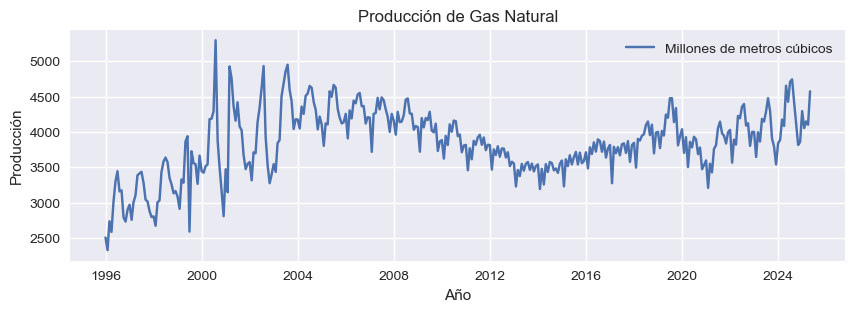

In [ ]:
# Visualizamos los datos
graficar(df_gas['produccion_gas_natural'], titulo='Producci√≥n de Gas Natural',
         xlabel='A√±o', ylabel='Producci√≥n', figsize=(10, 3),
         usar_leyenda=True, label='Millones de metros c√∫bicos')

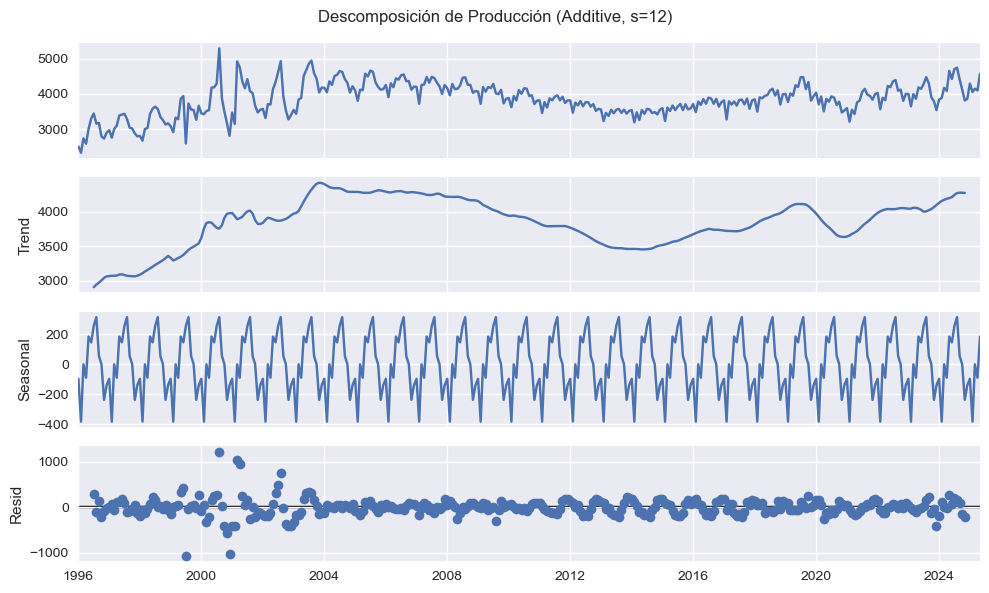

In [11]:
# Descomposici√≥n de la serie en diferentes componentes
decomp = seasonal_decompose(df_gas, model='additive', period=12)
fig = decomp.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Descomposici√≥n de Producci√≥n (Additive, s=12)')
plt.tight_layout()
plt.show()

- La **tendencia** revela un comportamiento no estacionario, lLa media de la serie no se mantiene constante a lo largo del tiempo.
- El **componente estacional** muestra un patr√≥n c√≠clico anual claramente definido y de amplitud pr√°cticamente constante durante toda la serie.
- Los **residuos** se distribuyen alrededor de cero sin evidenciar una estructura sistem√°tica o autocorrelaciones persistentes. No obstante, se observan algunos valores at√≠picos en determinados per√≠odos, como los a√±os 1999‚Äì2001.

----
## 4. An√°lisis de estacionariedad

#### ACF, PACF, Autocovarianzas 

In [12]:
# Funci√≥n para graficar ACF, PACF, autocovarianzas
## Fue construida a partir de la funci√≥n utilizada en un notebook del profesor, y con ChatGPT se le pidi√≥ que la reformule para que sea aplicable a una serie, y no dos. 
def graficar_acf_pacf_autocov(serie, n_lags=50, titulo="An√°lisis de correlaci√≥n temporal"):
    fig, axes = plt.subplots(3, 1, figsize=(8, 7), sharex=True)

    fig.suptitle(titulo, fontsize=12)

    # ACF
    plot_acf(serie, lags=n_lags, ax=axes[0], color='blue', 
             vlines_kwargs={"colors": 'blue'}, title="Autocorrelaci√≥n (ACF)")

    # PACF
    plot_pacf(serie, lags=n_lags, ax=axes[1], color='green', 
              vlines_kwargs={"colors": 'green'}, method='ywm', title="Autocorrelaci√≥n Parcial (PACF)")

    # Autocovarianzas
    autocov = tsa.acovf(serie, fft=False, nlag=n_lags)
    axes[2].plot(autocov, color='red')
    axes[2].set_title("Autocovarianzas")
    axes[2].set_xlabel("Lag")

    plt.tight_layout()
    plt.show()

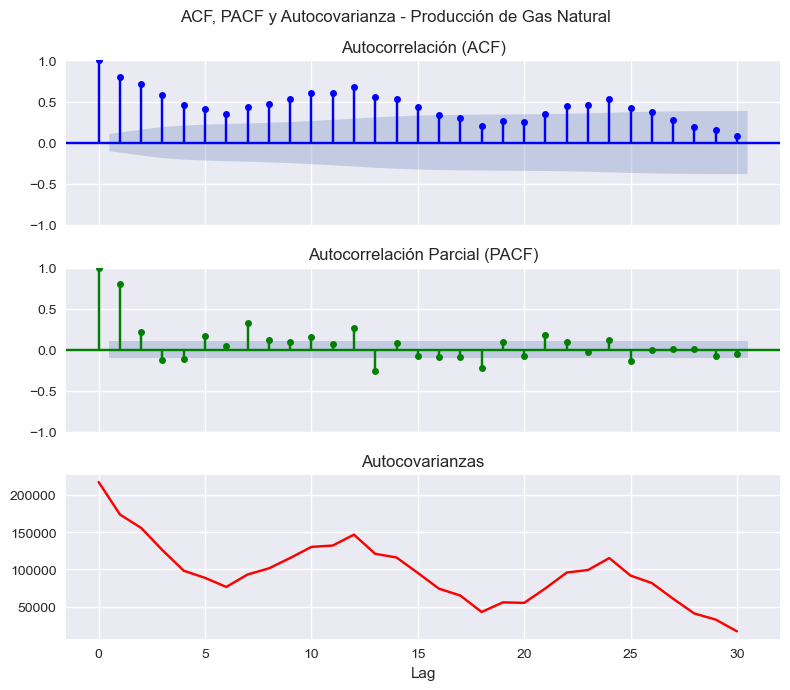

In [13]:
# Graficamos 
graficar_acf_pacf_autocov(df_gas, n_lags=30, 
                          titulo="ACF, PACF y Autocovarianza - Producci√≥n de Gas Natural")

- La **ACF** muestra una ca√≠da lenta y gradual, con valores significativamente distintos de cero incluso despu√©s de varios rezagos (lags), lo que sugiere no estacionariedad. 
- La **PACF** indica que el primer rezago es muy significativo y los siguientes caen r√°pidamente cerca de cero. Esto sugiere que un modelo AR(1) podr√≠a ser adecuado, ya que la mayor parte de la dependencia se explica con el primer rezago.
- Las **autocovarianzas** tambi√©n disminuyen con el lag, lo que refuerza la idea de que la serie tiene dependencia temporal, pero esta se va perdiendo a medida que aumenta el lag.

#### An√°lisis de la primera diferencia de la serie

In [14]:
# Aplicamos primera diferencia, para ver si se puede eliminar la estacionariedad
gas_diff = df_gas.diff().dropna()

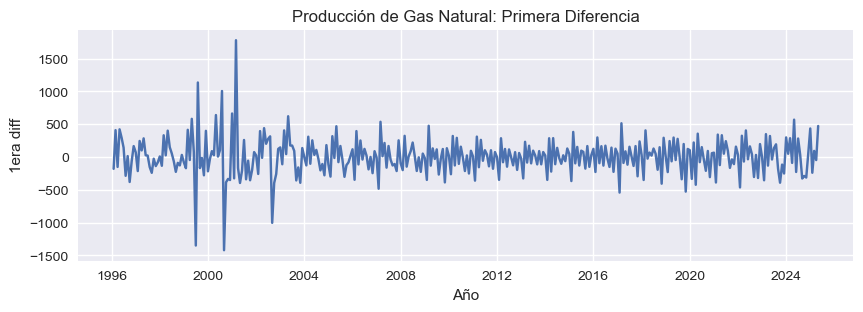

In [15]:
# Graficamos la primera diferencia
graficar(gas_diff, 
         titulo='Producci√≥n de Gas Natural: Primera Diferencia', 
         xlabel='A√±o', 
         ylabel='1era diff', 
         figsize=(10, 3))

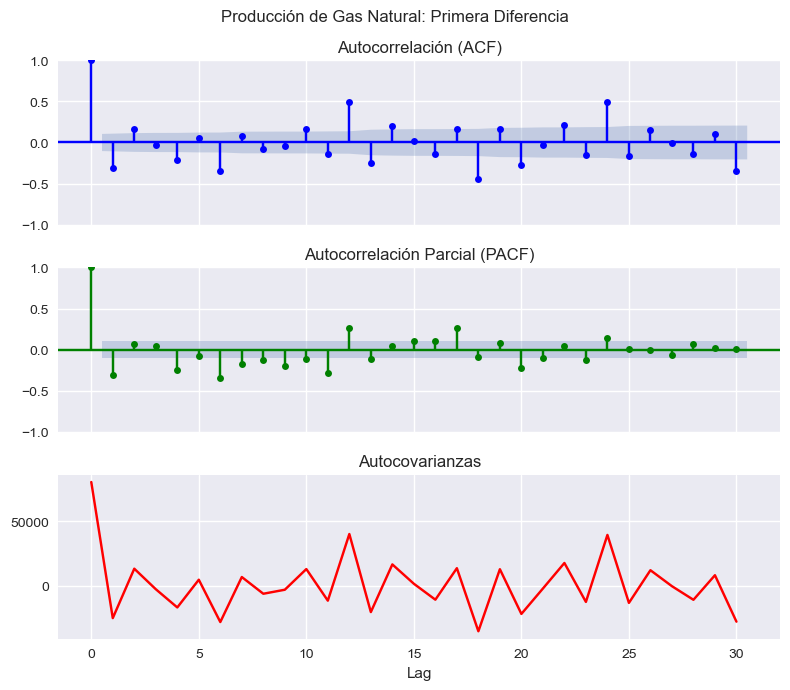

In [16]:
# Y su ACF, PACF y autocovarianzas
graficar_acf_pacf_autocov(gas_diff, n_lags=30, 
                          titulo="Producci√≥n de Gas Natural: Primera Diferencia")

- La **ACF** cae r√°pidamente a valores cercanos a cero despu√©s del primer rezago, y la mayor√≠a de los valores est√°n dentro del intervalo de confianza. Esto indica que la serie diferenciada es probablemente estacionaria, 
- En el gr√°fico de **PACF**, solo el primer rezago es claramente significativo, mientras que los siguientes est√°n cerca de cero. Esto sugiere que, tras la diferenciaci√≥n, la dependencia temporal se ha reducido considerablemente y un modelo ARMA simple podr√≠a ser adecuado.
- Las **autocovarianzas** oscilan alrededor de cero y no muestran una tendencia clara, lo que tambi√©n es caracter√≠stico de una serie estacionaria.

#### Test Dickey-Fuller Aumentado

In [17]:
# Funci√≥n para realizar test ADF
# Se utiliza el mismo que proporcion√≥ el profesor en la clase de pr√°ctica
# Se incorpor√≥ un componente adicional expresa si se rechaza o no la hip√≥tesis nula del test, construido con ChatGPT

def print_test_adf(y):
    resultado = adfuller(y.dropna())
    estadistico_adf = resultado[0]
    p_valor = resultado[1]
    criticos = resultado[4]

    print('Estad√≠stico ADF: %f' % estadistico_adf)
    print('p-valor: %f' % p_valor)
    print('Valores cr√≠ticos:')
    for clave, valor in criticos.items():
        print(f'   {clave}: {valor:.3f}')

    if p_valor < 0.05:
        print("Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
    else:
        print("No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")

In [18]:
# Testeamos la serie sin diferenciar
print_test_adf(df_gas)

Estad√≠stico ADF: -2.306551
p-valor: 0.169864
Valores cr√≠ticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [ ]:
# Testeamos la serie diferenciada
print_test_adf(gas_diff)

Estad√≠stico ADF: -4.048155
p-valor: 0.001178
Valores cr√≠ticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.


Los resultados de los tests ADF tambi√©n indican que la serie requiere una diferenciaci√≥n (d=1) para alcanzar estacionariedad.

#### Test KPSS

In [ ]:
from statsmodels.tsa.stattools import kpss

def test_kpss(serie, regression='c'):
    print(f"--- KPSS Test (regression='{regression}') ---")
    statistic, p_value, lags, crit_values = kpss(serie, regression=regression, nlags='auto')
    print(f'Estad√≠stico KPSS: {statistic:.4f}')
    print(f'p-valor: {p_value:.4f}')
    print(f'Lags usados: {lags}')
    print('Valores cr√≠ticos:')
    for key, value in crit_values.items():
        print(f'   {key}: {value}')
    if p_value < 0.05:
        print("‚ùå Se rechaza la hip√≥tesis nula: la serie NO es estacionaria.")
    else:
        print("‚úÖ No se rechaza la hip√≥tesis nula: la serie es estacionaria.")
    print()

# Ejemplo de uso:
test_kpss(df_gas['produccion_gas_natural'], regression='c')  # Solo constante
test_kpss(df_gas['produccion_gas_natural'], regression='ct') # Constante y tendencia

--- KPSS Test (regression='c') ---
Estad√≠stico KPSS: 0.5498
p-valor: 0.0304
Lags usados: 10
Valores cr√≠ticos:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
‚ùå Se rechaza la hip√≥tesis nula: la serie NO es estacionaria.

--- KPSS Test (regression='ct') ---
Estad√≠stico KPSS: 0.3969
p-valor: 0.0100
Lags usados: 10
Valores cr√≠ticos:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216
‚ùå Se rechaza la hip√≥tesis nula: la serie NO es estacionaria.



El test KPSS indica que la serie no es estacionaria, por lo que deber√≠a diferenciarse.

#### Componentes deterministicos - Test de Ra√≠ces Unitarias

In [20]:
# Funci√≥n para realizar los tres test de ra√≠ces unitarias
# Funci√≥n realizada con ChatGPT

def adf_test_multiple(series):
    opciones = {
        'n': 'Sin constante (None)',
        'c': 'Con constante (Drift)',
        'ct': 'Con constante y tendencia (Trend)'
    }

    for reg, descripcion in opciones.items():
        print(f"\n===== Test ADF - {descripcion} =====")
        resultado = adfuller(series.dropna(), regression=reg, autolag='AIC')
        estadistico = resultado[0]
        p_valor = resultado[1]
        criticos = resultado[4]

        print(f'Estad√≠stico ADF: {estadistico:.4f}')
        print(f'p-valor: {p_valor:.4f}')
        print('Valores cr√≠ticos:')
        for clave, valor in criticos.items():
            print(f'   {clave}: {valor:.3f}')

        if p_valor < 0.05:
            print("Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.")
        else:
            print("No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.")


In [21]:
# Testeamos la serie sin diferenciar
adf_test_multiple(df_gas)


===== Test ADF - Sin constante (None) =====
Estad√≠stico ADF: 0.4867
p-valor: 0.8218
Valores cr√≠ticos:
   1%: -2.572
   5%: -1.942
   10%: -1.616
No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estad√≠stico ADF: -2.3066
p-valor: 0.1699
Valores cr√≠ticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estad√≠stico ADF: -2.3127
p-valor: 0.4269
Valores cr√≠ticos:
   1%: -3.986
   5%: -3.424
   10%: -3.135
No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie NO es estacionaria.


In [22]:
# Testeamos la serie diferenciada
adf_test_multiple(gas_diff)


===== Test ADF - Sin constante (None) =====
Estad√≠stico ADF: -3.9807
p-valor: 0.0001
Valores cr√≠ticos:
   1%: -2.572
   5%: -1.942
   10%: -1.616
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estad√≠stico ADF: -4.0482
p-valor: 0.0012
Valores cr√≠ticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estad√≠stico ADF: -4.0385
p-valor: 0.0077
Valores cr√≠ticos:
   1%: -3.986
   5%: -3.424
   10%: -3.135
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.


Estos test siguen mostrando conclusiones coincidentes.

#### An√°lisis de la segunda diferencia de la serie

In [23]:
# Calculamos la serie diferenciada dos veces
gas_diff_2 = gas_diff.diff().dropna()

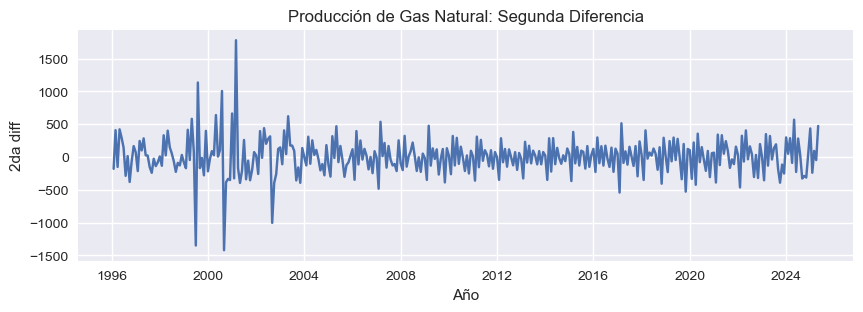

In [24]:
# Graficamos
graficar(gas_diff, 
         titulo='Producci√≥n de Gas Natural: Segunda Diferencia', 
         xlabel='A√±o', 
         ylabel='2da diff')

In [25]:
# Testeamos
print_test_adf(gas_diff_2)

Estad√≠stico ADF: -10.665728
p-valor: 0.000000
Valores cr√≠ticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.


In [26]:
# Tesetamos ra√≠ces unitarias
adf_test_multiple(gas_diff_2)


===== Test ADF - Sin constante (None) =====
Estad√≠stico ADF: -10.6822
p-valor: 0.0000
Valores cr√≠ticos:
   1%: -2.572
   5%: -1.942
   10%: -1.616
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante (Drift) =====
Estad√≠stico ADF: -10.6657
p-valor: 0.0000
Valores cr√≠ticos:
   1%: -3.450
   5%: -2.870
   10%: -2.571
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.

===== Test ADF - Con constante y tendencia (Trend) =====
Estad√≠stico ADF: -10.6536
p-valor: 0.0000
Valores cr√≠ticos:
   1%: -3.986
   5%: -3.424
   10%: -3.135
Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie es estacionaria.


#### Diferenciaci√≥n
¬øCu√°ntas veces debemos diferenciar? Realizamos diferentes tests para determinarlo. 

In [27]:
# Creamos una funci√≥n que lleva a cabo diferentes tests de diferenciaci√≥n √≥ptima
# A partir de la proporcionada por el profesor, fine-tuneada con ChatGPT

def test_estacionariedad(y, alpha=0.05):
    print("üîç Test de estacionariedad sugerida por distintos m√©todos")
    print("="*60)
    
    # Calcular cantidad de diferenciaciones sugeridas
    n_adf = ndiffs(y, test='adf')
    n_kpss = ndiffs(y, test='kpss')
    n_pp = ndiffs(y, test='pp')

    print(f"üìâ ADF test sugiere:   {n_adf} diferenciaci√≥n(es)")
    print(f"üìà KPSS test sugiere: {n_kpss} diferenciaci√≥n(es)")
    print(f"üìâ PP test sugiere:    {n_pp} diferenciaci√≥n(es)")
    print("-"*60)

    # Evaluar si al menos uno requiere diferenciaci√≥n
    if any(test > 0 for test in [n_adf, n_kpss, n_pp]):
        print("Al menos uno de los tests sugiere diferenciar ‚Üí Se recomienda aplicar diferenciaci√≥n.")
    else:
        print("Ning√∫n test sugiere diferenciar ‚Üí La serie probablemente es estacionaria.")
    
    print("="*60)

In [28]:
test_estacionariedad(df_gas)

üîç Test de estacionariedad sugerida por distintos m√©todos
üìâ ADF test sugiere:   1 diferenciaci√≥n(es)
üìà KPSS test sugiere: 1 diferenciaci√≥n(es)
üìâ PP test sugiere:    0 diferenciaci√≥n(es)
------------------------------------------------------------
Al menos uno de los tests sugiere diferenciar ‚Üí Se recomienda aplicar diferenciaci√≥n.


In [29]:
test_estacionariedad(gas_diff)

üîç Test de estacionariedad sugerida por distintos m√©todos
üìâ ADF test sugiere:   0 diferenciaci√≥n(es)
üìà KPSS test sugiere: 0 diferenciaci√≥n(es)
üìâ PP test sugiere:    0 diferenciaci√≥n(es)
------------------------------------------------------------
Ning√∫n test sugiere diferenciar ‚Üí La serie probablemente es estacionaria.


Los resultados de los test de estacionariedad sugieren que es apropiado aplicar una primera diferenciaci√≥n para estabilizar la serie. En consecuencia, al momento de especificar el modelo, se establece un orden de integraci√≥n d=1.

----
## 5. An√°lisis de estacionalidad

In [30]:
# An√°lisis de estacionalidad a partir de una funci√≥n creada con ayuda de ChatGPT

# Intuimos que la serie tiene estacionalidad cada 12 meses, por los graficos de ACF y PACF y porque es una serie con datos mensuales
# Por ello, aplicamos la 12ava diferencia a la serie original

# Test Canova-Hansen
## Para estimar el n√∫mero de diferencias estacionales necesarias en la serie
def print_test_ch(series):
    resultado = CHTest(m=12).estimate_seasonal_differencing_term(series)  # m=12 
    d_seas = resultado
    print("Canova-Hansen: N√∫mero de diferencias estacionales sugeridas:", d_seas)
    if d_seas > 0:
        print("Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie tiene estacionalidad.")
    else:
        print("No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.")

# Test OCSB
## Para evaluar la presencia de ra√≠ces unitarias estacionales
def print_test_ocsb(series):
    resultado = OCSBTest(m=12).estimate_seasonal_differencing_term(series)  # m=12 
    print("OCSB Test: N√∫mero de diferencias estacionales sugeridas:", resultado)
    if resultado > 0:
        print("Se rechaza la hip√≥tesis nula con un nivel de significancia del 5%: la serie tiene estacionalidad.")
    else:
        print("No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.")

# Testeamos la serie sin diferenciar
series = df_gas['produccion_gas_natural'].values

print_test_ch(series)  
print_test_ocsb(series)


Canova-Hansen: N√∫mero de diferencias estacionales sugeridas: 0
No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.
OCSB Test: N√∫mero de diferencias estacionales sugeridas: 0
No se puede rechazar la hip√≥tesis nula con un nivel de significancia del 5%: la serie no tiene estacionalidad.


Ambos tests, Canova-Hansen y OCSB, coinciden en que no es necesario aplicar diferencias estacionales a la serie.

----
## 6. Analizar la posibilidad de transformaci√≥n Box-Cox

#### Test de Jarque Bera para la normalidad de los residuos

In [32]:
# Creamos una funci√≥n para evaluar la normalidad con Jarque-Bera y Shapiro-Wilk con ayuda de ChatGPT
def test_normalidad(serie):
    # Test Jarque-Bera
    jb_stat, jb_pvalue = jarque_bera(serie)

    print("===== Test de Normalidad Jarque-Bera =====")
    print(f"Estad√≠stico Jarque-Bera: {jb_stat:.4f}")
    print(f"p-valor: {jb_pvalue:.4f}")

    if jb_pvalue > 0.05:
        print("‚úÖ No se rechaza la hip√≥tesis nula: los residuos tienen distribuci√≥n normal (al 5%)")
    else:
        print("‚ùå Se rechaza la hip√≥tesis nula: los residuos NO siguen una distribuci√≥n normal (al 5%)")

    print("\n===== Test de Normalidad Shapiro-Wilk =====")
    # Test Shapiro-Wilk
    shapiro_stat, shapiro_pvalue = shapiro(serie)
    print(f"Estad√≠stico Shapiro-Wilk: {shapiro_stat:.4f}")
    print(f"p-valor: {shapiro_pvalue:.4f}")

    if shapiro_pvalue > 0.05:
        print("‚úÖ No se rechaza la hip√≥tesis nula: los residuos tienen distribuci√≥n normal (al 5%)")
    else:
        print("‚ùå Se rechaza la hip√≥tesis nula: los residuos NO siguen una distribuci√≥n normal (al 5%)")

# Ejecuci√≥n del test sobre la serie original
test_normalidad(df_gas)


===== Test de Normalidad Jarque-Bera =====
Estad√≠stico Jarque-Bera: 5.5277
p-valor: 0.0630
‚úÖ No se rechaza la hip√≥tesis nula: los residuos tienen distribuci√≥n normal (al 5%)

===== Test de Normalidad Shapiro-Wilk =====
Estad√≠stico Shapiro-Wilk: 0.9926
p-valor: 0.0801
‚úÖ No se rechaza la hip√≥tesis nula: los residuos tienen distribuci√≥n normal (al 5%)


Ambos test coinciden en que no es necesario aplicar la transformaci√≥n Box-Cox.

---- 
## 7. Partici√≥n *train* y *test set*

Se mantiene el 90% de los datos para entrenamiento y el 10% restante para prueba, con el fin de matener una coherencia metodol√≥gica con las otras series elegidas para este trabajo.

In [33]:
# Tomamos la columna del gas como una serie
serie = df_gas[df_gas.columns[0]]

In [34]:
# Definimos el tama√±o del corte: 90% para el train, 10% para el test
n_total = len(serie)
n_train = int(n_total * 0.9)

In [35]:
# Divisi√≥n train / test
train = serie.iloc[:n_train]
test = serie.iloc[n_train:]

In [36]:
# Mostram tama√±os
print(f"Observaciones totales: {n_total}")
print(f"Train: {len(train)} datos")
print(f"Test: {len(test)} datos")

Observaciones totales: 353
Train: 317 datos
Test: 36 datos


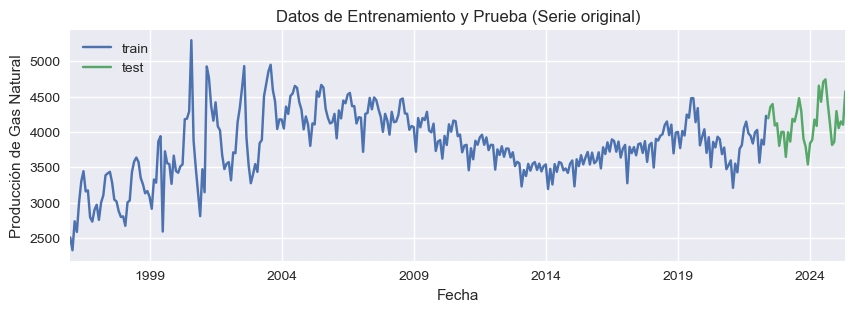

In [37]:
# Observamos los datos particionados
fig, ax = plt.subplots(figsize=(10, 3))
train.plot(ax=ax)
test.plot(ax=ax)
plt.title("Datos de Entrenamiento y Prueba (Serie original)")
plt.legend(['train', 'test'])
plt.xlabel('Fecha')
plt.ylabel('Producci√≥n de Gas Natural')
plt.show()

-----
## 8. Estimaci√≥n del modelo

#### Primer modelo: ARIMA(1,1,1)

Previamente, eg√∫n los gr√°ficos y test realizados, un modelo adecuado podr√≠a ser un **ARIMA (1,1,1)** ya que:
- d = 1: porque se aplic√≥ la primera diferencia para lograr estacionariedad.
- p = 1: porque en la PACF solo el primer rezago es significativo.
- q = 1: porque en la ACF solo el primer rezago podr√≠a ser levemente significativo y luego cae r√°pidamente.
As√≠ que es el primer modelo elegido.

In [38]:
# Modelo ARIMA
order = (1, 1, 1)

# Modelo sobre la serie original (sin Box-Cox)
modelo_arima = ARIMA(train, order=order)
results = modelo_arima.fit()

# Resumen del modelo
print(results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     produccion_gas_natural   No. Observations:                  317
Model:                     ARIMA(1, 1, 1)   Log Likelihood               -2219.081
Date:                    Tue, 08 Jul 2025   AIC                           4444.163
Time:                            23:56:29   BIC                           4455.430
Sample:                        01-01-1996   HQIC                          4448.664
                             - 05-01-2022                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4328      0.100     -4.312      0.000      -0.630      -0.236
ma.L1          0.1197      0.108      1.104      0.269      -0.093       0.332
sigma2      7.373e+0

#### Segundo modelo: Grid Search para la obtenci√≥n del modelo ARIMA √≥ptimo por criterio AIC

Grid Search consiste en probar todas las combinaciones posibles de un conjunto de hiperpar√°metros (en este caso, los valores de p, d y q) y seleccionar la combinaci√≥n que optimiza un criterio (aqu√≠, el AIC).
En este c√≥digo, se recorren todos los valores posibles definidos para p, d y q, se ajusta un modelo ARIMA para cada combinaci√≥n y se guarda el modelo con el menor AIC.

In [ ]:
# Funci√≥n realizada con ChatGPT

# Rangos de b√∫squeda
p_values = range(0, 5) 
d_values = range(0, 5)
q_values = range(0, 5)

# Variables para guardar el mejor modelo
best_aic = np.inf
best_order = None
best_model = None

# B√∫squeda exhaustiva
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
            except:
                continue  # Saltea combinaciones que no converjan

# Resultados
print(f"Mejor modelo ARIMA: {best_order} con AIC: {best_aic}")
print(best_model.summary())

Mejor modelo ARIMA: (2, 4, 4) con AIC: 14.0
                                 SARIMAX Results                                  
Dep. Variable:     produccion_gas_natural   No. Observations:                  317
Model:                     ARIMA(2, 4, 4)   Log Likelihood                   0.000
Date:                    Tue, 08 Jul 2025   AIC                             14.000
Time:                            23:56:43   BIC                             40.223
Sample:                        01-01-1996   HQIC                            24.480
                             - 05-01-2022                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -1.431e-05   3.62e-09  -3952.715      0.000   -1.43e-05   -1.43e-05
ar.L2          1.0000   7.66e-08   1.31e+07      0.000 

#### Tercer modelo: Grid Search para la obtenci√≥n del modelo ARIMA √≥ptimo por criterio BIC

In [ ]:
# Rangos de b√∫squeda
p_values = range(0, 5)  
d_values = range(0, 5)
q_values = range(0, 5)

# Variables para guardar el mejor modelo
best_bic = np.inf
best_order = None
best_model = None

# B√∫squeda exhaustiva por BIC
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                results = model.fit()

                if results.bic < best_bic:
                    best_bic = results.bic
                    best_order = (p, d, q)
                    best_model = results

            except:
                continue  # Salta combinaciones no v√°lidas

# Resultados
print(f"Mejor modelo ARIMA por BIC: {best_order} con BIC: {best_bic}")
print(best_model.summary())

Mejor modelo ARIMA por BIC: (2, 4, 4) con BIC: 40.22342233378107
                                 SARIMAX Results                                  
Dep. Variable:     produccion_gas_natural   No. Observations:                  317
Model:                     ARIMA(2, 4, 4)   Log Likelihood                   0.000
Date:                    Tue, 08 Jul 2025   AIC                             14.000
Time:                            23:56:58   BIC                             40.223
Sample:                        01-01-1996   HQIC                            24.480
                             - 05-01-2022                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -1.431e-05   3.62e-09  -3952.715      0.000   -1.43e-05   -1.43e-05
ar.L2          1.0000   7.66e-08  

Como resultado, se obtuvo el mismo modelo √≥ptimo que por el criterio de AIC. As√≠ que se lo considera una sola vez.

#### Cuarto modelo: Modelo SARIMA √≥ptimo sin intercepto

Si bien los tests de Canova-Hansen y OCSB indicaron que no es necesario realizar diferencias estacionales, gr√°ficamente se aprecia la posible presencia de un patr√≥n estacional. Por este motivo, a continuaci√≥n se prueban modelos SARIMA con el objetivo de comparar su desempe√±o frente a los modelos ARIMA y, de esta forma, determinar el modelo √≥ptimo.

In [43]:
# Funci√≥n realizada con ChatGPT
 
# SARIMA √≥ptimo SIN intercepto
print("üîç Buscando modelo SARIMAX √≥ptimo (sin intercepto)...")
auto_sarimax = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1,
    D=0,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='bic',
    random_state=42
)

# Ajustar el modelo √≥ptimo con statsmodels
modelo_optimo = SARIMAX(
    train,
    order=auto_sarimax.order,
    seasonal_order=auto_sarimax.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultados_optimos = modelo_optimo.fit(disp=False)

print(f"\nMejor modelo SARIMAX por BIC: {auto_sarimax.order} x {auto_sarimax.seasonal_order} con BIC: {resultados_optimos.bic:.3f}")
print(resultados_optimos.summary())

üîç Buscando modelo SARIMAX √≥ptimo (sin intercepto)...
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=4485.411, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=4387.823, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=4421.713, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=4479.769, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=4456.029, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=4351.417, Time=0.36 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=4326.997, Time=0.95 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=4321.465, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=4419.814, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=4327.002, Time=0.89 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=4389.650, Time=0.29 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=4336.149, Time=0.37 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept

El modelo con menor valor de BIC en toda la lista es SARIMA(1,1,1)(1,0,1)[12] con un BIC de 4297.

In [ ]:
modelo_optimo = SARIMAX(
    serie,  
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Muestra el resumen
print(modelo_optimo.summary())

                                     SARIMAX Results                                      
Dep. Variable:             produccion_gas_natural   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2271.626
Date:                            Wed, 09 Jul 2025   AIC                           4553.253
Time:                                    20:06:19   BIC                           4572.368
Sample:                                01-01-1996   HQIC                          4560.871
                                     - 05-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5010      0.047     10.672      0.000       0.409       0.593
ma.L1         -0.8791      0.042   

### Validaci√≥n cruzada

In [88]:
# Funci√≥n realizada con ChatGPT

tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(serie):
    train_cv, test_cv = serie.iloc[train_index], serie.iloc[test_index]
    # Ajusta el modelo SARIMAX con los par√°metros √≥ptimos
    modelo_cv = SARIMAX(
        train_cv,
        order=(1,1,1),
        seasonal_order=(1,0,1,12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    pred_cv = modelo_cv.forecast(steps=len(test_cv))
    mse = mean_squared_error(test_cv, pred_cv)
    mse_scores.append(mse)

print("MSE en cada fold:", mse_scores)
print("MSE promedio:", np.mean(mse_scores))

MSE en cada fold: [478803.8922685196, 562278.0442834328, 206213.75686853047, 230079.01268707745, 75276.67538027343]
MSE promedio: 310530.2762975668


- La validaci√≥n cruzada temporal muestra que el modelo SARIMAX(1,1,1)(1,0,1,12) mantiene un error de predicci√≥n razonable y estable a lo largo de diferentes periodos de la serie y no hay sobreajuste a un solo periodo, lo que respalda su robustez y capacidad de generalizaci√≥n ya que no depende de un solo corte train/test.
- Aunque si hay cierta variabilidad entre los folds: los primeros dos tienen errores m√°s altos, los √∫ltimos dos son intermedios y el √∫ltimo es el m√°s bajo. Sin embargo, sto es normal en series temporales, especialmente si los primeros folds predicen periodos m√°s antiguos o si hay outliers o cambios estructurales en la serie.


#### Quinto modelo: Modelo SARIMA √≥ptimo con intercepto

In [44]:
# SARIMA √≥ptimo CON intercepto
print("\nüîç Buscando modelo SARIMAX √≥ptimo (con intercepto)...")
auto_sarimax_c = auto_arima(
    train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1,
    D=0,
    seasonal=True,
    m=12,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='bic',
    random_state=42,
    trend='c'  # Intercepto
)

modelo_optimo_c = SARIMAX(
    train,
    order=auto_sarimax_c.order,
    seasonal_order=auto_sarimax_c.seasonal_order,
    trend='c',
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultados_optimos_c = modelo_optimo_c.fit(disp=False)

print(f"\nMejor modelo SARIMAX (con intercepto) por BIC: {auto_sarimax_c.order} x {auto_sarimax_c.seasonal_order} con BIC: {resultados_optimos_c.bic:.3f}")
print(resultados_optimos_c.summary())


üîç Buscando modelo SARIMAX √≥ptimo (con intercepto)...
Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=4485.411, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=4387.823, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=4421.713, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=4485.411, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=4456.029, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : BIC=4351.417, Time=0.34 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : BIC=4326.997, Time=0.94 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : BIC=4321.465, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=4419.814, Time=0.10 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : BIC=4327.002, Time=0.88 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : BIC=4389.650, Time=0.30 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : BIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=4336.149, Time=0.21 sec
 ARIMA(2,1,0)(1,0,1)[12] intercep

El modelo con menor valor de BIC en toda la lista es SARIMA(1,1,1)(1,0,1)[12] con un BIC de 4297.

----
## 9. Elecci√≥n de modelo
Creamos una tabla resumen con las principales caracter√≠sticas de los modelos probados

In [ ]:
# Modelo 1: ARIMA(1,1,1)
modelo_1 = ARIMA(train, order=(1, 1, 1)).fit()

# Modelo 2: ARIMA(2,4,4)
modelo_2 = ARIMA(train, order=(2, 4, 4)).fit()

# Modelo 4: SARIMAX(1,1,1)(1,0,1,12) sin intercepto
modelo_4 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False).fit()

# Modelo 5: SARIMAX(1,1,1)(1,0,1,12) con intercepto
modelo_5 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,1,12), trend='c', enforce_stationarity=False, enforce_invertibility=False).fit()

modelos = [
    {
        'Modelo': 'Modelo 1',
        'ARIMA(p,d,q)': (1, 1, 1),
        'Seasonal(P,D,Q,s)': '-',
        'Intercepto': 'No',
        'result': modelo_1
    },
    {
        'Modelo': 'Modelo 2',
        'ARIMA(p,d,q)': (2, 4, 4),
        'Seasonal(P,D,Q,s)': '-',
        'Intercepto': 'No',
        'result': modelo_2
    },
    {
        'Modelo': 'Modelo 4',
        'ARIMA(p,d,q)': (1, 1, 1),
        'Seasonal(P,D,Q,s)': (1, 0, 1, 12),
        'Intercepto': 'No',
        'result': modelo_4
    },
    {
        'Modelo': 'Modelo 5',
        'ARIMA(p,d,q)': (1, 1, 1),
        'Seasonal(P,D,Q,s)': (1, 0, 1, 12),
        'Intercepto': 'S√≠',
        'result': modelo_5
    }
]

filas = []
for m in modelos:
    res = m['result']
    pred_train = res.fittedvalues
    rmse = np.sqrt(mean_squared_error(train, pred_train))
    pvals = res.pvalues
    significativos = sum(p < 0.05 for p in pvals)
    filas.append({
        'Modelo': m['Modelo'],
        'ARIMA(p,d,q)': m['ARIMA(p,d,q)'],
        'Seasonal(P,D,Q,s)': m['Seasonal(P,D,Q,s)'],
        'Intercepto': m['Intercepto'],
        'AIC': round(res.aic, 2),
        'BIC': round(res.bic, 2),
        'RMSE Train': round(rmse, 2),
        'Coef. Significativos': f"{significativos}/{len(pvals)}"
    })

df_comparacion = pd.DataFrame(filas)
display(df_comparacion)

Modelo ARIMA(p,d,q) Seasonal(P,D,Q,s) Intercepto      AIC      BIC  \
0  Modelo 1    (1, 1, 1)                 -         No  4444.16  4455.43   
1  Modelo 2    (2, 4, 4)                 -         No    14.00    40.22   
2  Modelo 4    (1, 1, 1)     (1, 0, 1, 12)         No  4080.13  4098.68   
3  Modelo 5    (1, 1, 1)     (1, 0, 1, 12)         S√≠  4085.10  4107.36   

     RMSE Train Coef. Significativos  
0  3.052600e+02                  2/3  
1  1.085190e+11                  7/7  
2  2.633100e+02                  5/5  
3  2.625600e+02                  5/6

Sin embargo: 
#### ‚ÄúLa precisi√≥n de los pron√≥sticos s√≥lo se puede determinar considerando qu√© tan bien se desempe√±a un modelo con los nuevos datos que no se utilizaron al ajustar el modelo.‚Äù
Por lo que a continuaci√≥n se calcular√°n distintas m√©tricas sobre el conjunto de prueba. 

#### Generaci√≥n de predicciones sobre el conjunto de testeo

In [50]:
# Tama√±o del set de test
n_test = len(test)
print("Tama√±o del test:", n_test)

# Funci√≥n para evaluar m√©tricas
def evaluar_metricas(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f'MSE:  {mse:.4f}')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')

# Pron√≥sticos y m√©tricas para cada modelo
# 1. Modelo 1: ARIMA(1,1,1)
pred_1 = modelo_1.get_forecast(steps=n_test).predicted_mean
print('--- M√©tricas Modelo 1 ---')
evaluar_metricas(test, pred_1)
print()

# 2. Modelo 2: ARIMA(2,4,4)
pred_2 = modelo_2.get_forecast(steps=n_test).predicted_mean
print('--- M√©tricas Modelo 2 ---')
evaluar_metricas(test, pred_2)
print()

# 3. Modelo 4: SARIMAX(1,1,1)(1,0,1,12) sin intercepto
pred_4 = modelo_4.get_forecast(steps=n_test).predicted_mean
print('--- M√©tricas Modelo 4 ---')
evaluar_metricas(test, pred_4)
print()

# 4. Modelo 5: SARIMAX(1,1,1)(1,0,1,12) con intercepto
pred_5 = modelo_5.get_forecast(steps=n_test).predicted_mean
print('--- M√©tricas Modelo 5 ---')
evaluar_metricas(test, pred_5)
print()

Tama√±o del test: 36
--- M√©tricas Modelo 1 ---
MSE:  83132.0366
MAE:  229.2465
RMSE: 288.3263
MAPE: 5.55%

--- M√©tricas Modelo 2 ---
MSE:  169414342029963192958976.0000
MAE:  408487498793.6555
RMSE: 411599735216.0995
MAPE: 9901042657.84%

--- M√©tricas Modelo 4 ---
MSE:  69908.0392
MAE:  209.2534
RMSE: 264.4013
MAPE: 4.90%

--- M√©tricas Modelo 5 ---
MSE:  151962.1011
MAE:  313.1273
RMSE: 389.8232
MAPE: 7.29%



### **An√°lisis comparativo de modelos**
**ARIMA(1,1,1)**
Este modelo logra un desempe√±o razonable, con un MAPE bajo (5.55%) y errores moderados. Aunque aceptable, es superado por modelos que incorporan estacionalidad.

**ARIMA(2,4,4)**
A pesar de tener los AIC/BIC m√°s bajos, los errores de predicci√≥n (MSE, MAE, RMSE, MAPE) son desmesuradamente altos, lo que evidencia un mal ajuste o inestabilidad num√©rica. Debe descartarse.

**SARIMAX(1,1,1)(1,0,1)[12] sin intercepto**
Este modelo presenta los mejores resultados, con los errores m√°s bajos en todas las m√©tricas. Adem√°s, los coeficientes son estad√≠sticamente significativos. Captura adecuadamente la estacionalidad y generaliza mejor que los dem√°s modelos.

**SARIMAX(1,1,1)(1,0,1)[12] con intercepto**
Incorpora un t√©rmino adicional sin mejoras relevantes. Sus errores son mayores que el mismo modelo sin intercepto. El coeficiente del intercepto no es significativo, por lo que su inclusi√≥n no se justifica.


> **Conclusi√≥n: El mejor modelo para tu serie es el SARIMAX(1,1,1)(1,0,1,12) sin intercepto.**

## Modelo seleccionado: **SARIMAX(1,1,1)(1,0,1,12)**

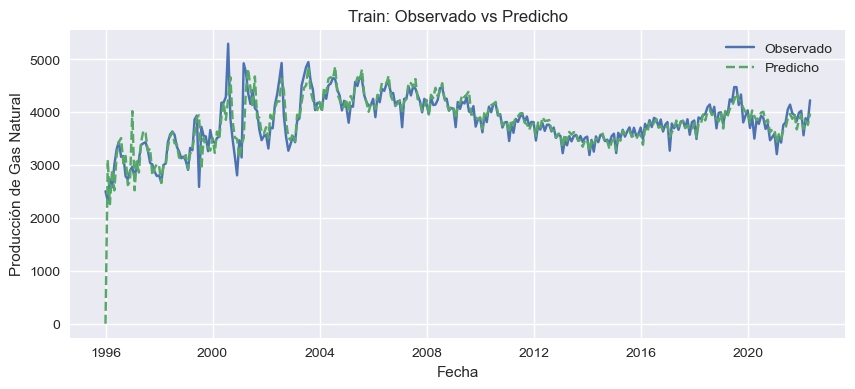

In [51]:
# Predicci√≥n en el conjunto de entrenamiento
train_pred = modelo_4.predict(start=train.index[0], end=train.index[-1])

plt.figure(figsize=(10, 4))
plt.plot(train, label='Observado')
plt.plot(train_pred, label='Predicho', linestyle='--')
plt.title("Train: Observado vs Predicho")
plt.xlabel("Fecha")
plt.ylabel("Producci√≥n de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()

**Conclusiones del gr√°fico:**

1. **Ajuste muy bueno en el entrenamiento**
   - La l√≠nea predicha (verde, discontinua) sigue muy de cerca a la observada (azul) durante casi todo el per√≠odo. Esto indica que el modelo  logra capturar muy bien la din√°mica de la serie en el conjunto de entrenamiento.

2. **Captura de la estacionalidad y tendencia**
   - El modelo reproduce correctamente los picos, valles y la estacionalidad de la serie.
   - Tambi√©n sigue la tendencia general de la producci√≥n de gas natural a lo largo de los a√±os.
   - Aunque hay algunos momentos (especialmente en los extremos de la serie o en picos muy abruptos) donde el modelo no logra capturar completamente la magnitud de los cambios, pero en general el ajuste es excelente.

3. **No hay signos de sobreajuste**
   - La predicci√≥n no es excesivamente ‚Äúpegada‚Äù a los valores observados, lo que sugiere que el modelo es flexible pero no sobreajustado.


> **El modelo reproduce fielmente la serie hist√≥rica en el entrenamiento, capturando tanto la tendencia como la estacionalidad. Es robusto y confiable para esta serie temporal.**

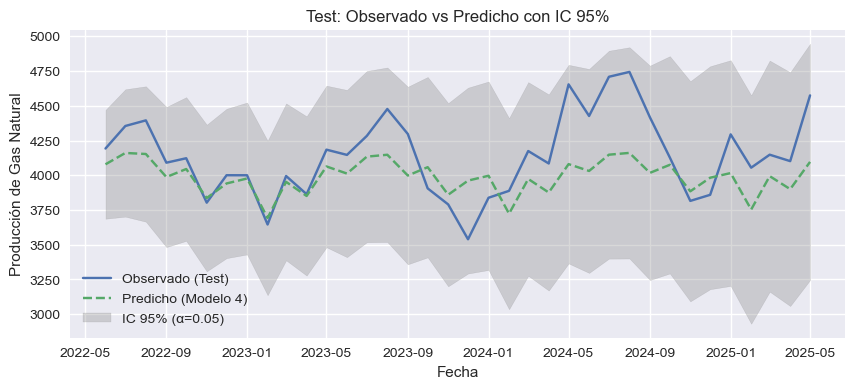

In [52]:
# Forecast y IC en el conjunto de test
n_test = len(test)
fc = modelo_4.get_forecast(steps=n_test)
pred_4 = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

plt.figure(figsize=(10, 4))
plt.plot(test.index, test, label='Observado (Test)')
plt.plot(pred_4.index, pred_4, linestyle='--', label='Predicho (Modelo 4)')

# Sombrear el intervalo de confianza
plt.fill_between(
    ci.index,
    ci.iloc[:, 0],   # l√≠mite inferior
    ci.iloc[:, 1],   # l√≠mite superior
    color='gray',
    alpha=0.3,
    label='IC 95% (Œ±=0.05)'
)

plt.title("Test: Observado vs Predicho con IC 95%")
plt.xlabel("Fecha")
plt.ylabel("Producci√≥n de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()

> El modelo SARIMAX predice bien la tendencia y la estacionalidad en el set de test, aunque suaviza los extremos. La mayor√≠a de los valores reales caen dentro del intervalo de confianza, lo que indica que el modelo es confiable para pron√≥stico, aunque no perfecto para eventos abruptos.

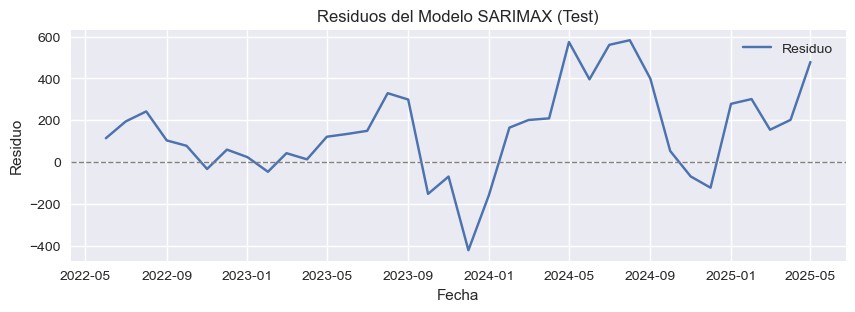

In [53]:
# C√°lculo de residuos en el test
residuos_test = test - pred_4

plt.figure(figsize=(10, 3))
plt.plot(residuos_test, label='Residuo')
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMAX (Test)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.legend()
plt.show()

> El modelo se ajusta bien la serie: los residuos en el test est√°n centrados en cero, no muestran patrones sistem√°ticos (no sobreestima ni subestima de manera constante) y su magnitud es razonable. Los errores m√°s grandes coinciden con los picos y valles que el modelo suaviza tal cmo se observa en el gr√°fico anterior, pero no hay evidencia de problemas graves de ajuste. Tampoco hay evidencia de heterocedasticidad grave (varianza creciente o decreciente a lo largo del tiempo).

----
## 10. An√°lisis de diagn√≥stico

1. Gr√°fico de residuos en el conjunto de entrenamiento

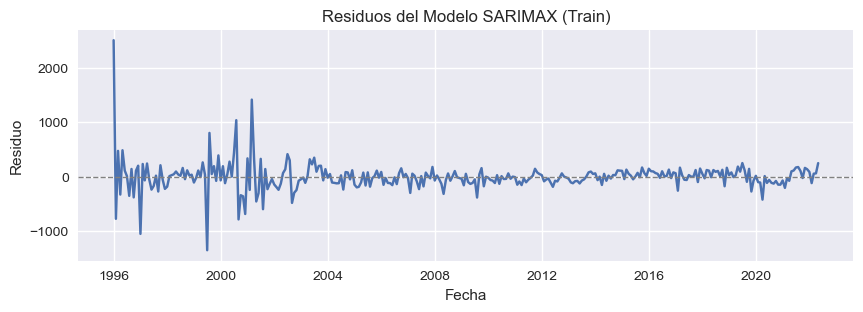

In [56]:
# Residuos del modelo en el conjunto de entrenamiento
residuos_train = modelo_4.resid

plt.figure(figsize=(10, 3))
plt.plot(residuos_train)
plt.axhline(y=0, color='grey', linestyle='--', linewidth=1)
plt.title("Residuos del Modelo SARIMAX (Train)")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.grid(True)
plt.show()

- Adicionalmente a las conclusiones anteriores, se observan algunos residuos muy grandes (tanto positivos como negativos) al principio de la serie (antes del a√±o 2000). Esto puede deberse a problemas de ajuste inicial del modelo o cambios estructurales o datos at√≠picos.
- Sin embargo, a partir del a√±o 2000, los residuos se estabilizan y permanecen en un rango mucho m√°s acotado, lo que indica que el modelo ajusta bien la mayor parte de la serie hist√≥rica.

2. ACF y PACF de los residuos

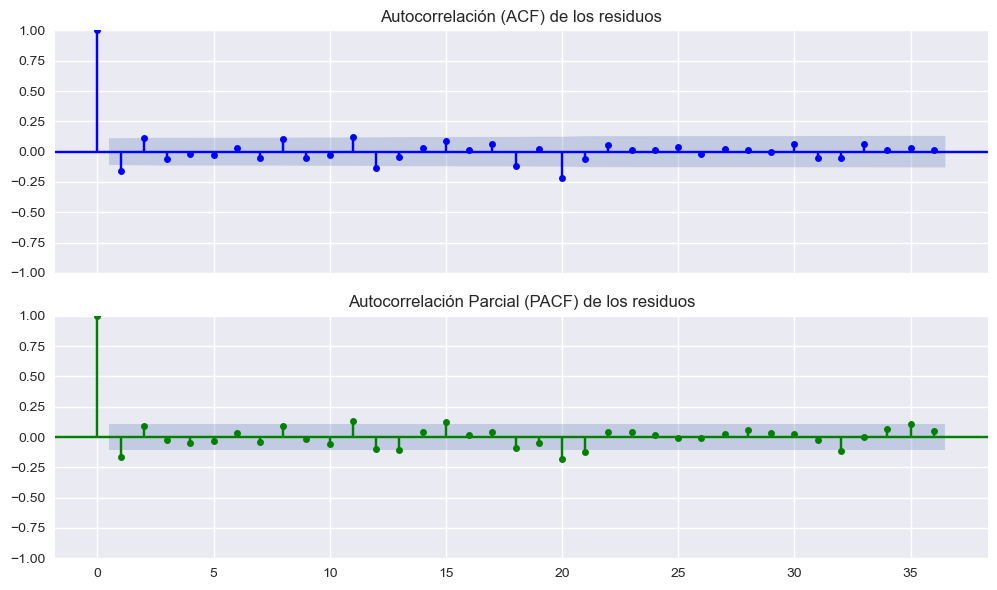

In [64]:
# Calcula los residuos del modelo en el conjunto de entrenamiento
residuos_train = modelo_4.resid

# Gr√°fico de ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ACF
plot_acf(residuos_train, lags=36, ax=axes[0], color='blue', vlines_kwargs={'colors':'blue'})
axes[0].set_title('Autocorrelaci√≥n (ACF) de los residuos')

# PACF
plot_pacf(residuos_train, lags=36, ax=axes[1], color='green', vlines_kwargs={'colors':'green'}, method='ywm')
axes[1].set_title('Autocorrelaci√≥n Parcial (PACF) de los residuos')

plt.tight_layout()
plt.show()

   - Excepto el primer lag (que siempre es 1 por definici√≥n), casi todos los valores de la ACF y PACF est√°n dentro de la banda azul de confianza (aproximadamente ¬±2/‚àöN).
   - La ausencia de autocorrelaci√≥n significativa en los residuos indica que el modelo actual es suficiente para capturar la din√°mica de la serie.
   - Tampoco hay patrones peri√≥dicos, lo que sugiere que los residuos son esencialmente ruido blanco.
   - El primer valor de la ACF y PACF siempre es 1, ya que es la autocorrelaci√≥n de la serie consigo misma. No debe interpretarse como un problema.


3. Diagn√≥stico gr√°fico de residuos para el modelo

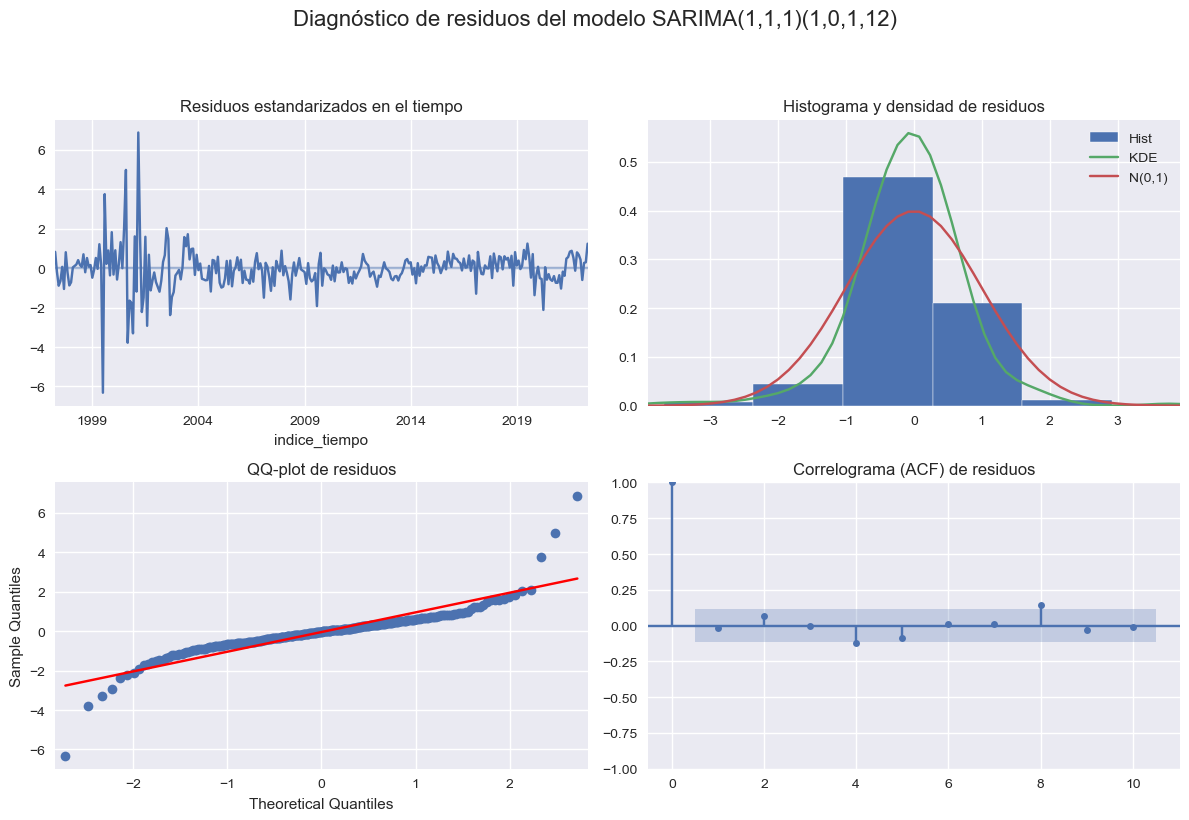

In [97]:
fig = modelo_4.plot_diagnostics(figsize=(12, 8))

# Mejorar los t√≠tulos y el espaciado
fig.suptitle("Diagn√≥stico de residuos del modelo SARIMA(1,1,1)(1,0,1,12)", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Ajusta el espacio para el t√≠tulo principal

# Opcional: puedes ajustar los t√≠tulos de los subgr√°ficos si lo deseas
axes = fig.get_axes()
axes[0].set_title("Residuos estandarizados en el tiempo")
axes[1].set_title("Histograma y densidad de residuos")
axes[2].set_title("QQ-plot de residuos")
axes[3].set_title("Correlograma (ACF) de residuos")

plt.show()

**1. Residuos estandarizados en el tiempo**: Los residuos est√°n centrados en torno a cero durante la mayor parte del per√≠odo, aunque hay algunos valores extremos al inicio (outliers). Esto es com√∫n en series largas, especialmente si hay cambios estructurales o menor ajuste al principio; sin embargo, en la mayor parte de la serie, los residuos son peque√±os y estables.

**2. Histograma de los residuos**: En general, los residuos se aproximan a la normalidad, aunque cierta asimetr√≠a y colas algo m√°s pesadas.

**3. QQ-plot**: Nuevamente, se observa que los residuos son aproximadamente normales, hay algunos desv√≠os en las colas.

**4. Correlograma**: Todos los valores est√°n dentro de las bandas de confianza, lo que indica ausencia de autocorrelaci√≥n significativa en los residuos.


> Conclusi√≥n: El modelo SARIMAX ajusta bien la serie: los residuos son aproximadamente normales, no presentan autocorrelaci√≥n y est√°n centrados en cero. Los outliers al inicio no afectan el buen desempe√±o general.

4. Test de heterocedasticidad (ARCH)


In [86]:
residuos = modelo_4.resid

arch_test = het_arch(residuos)
print("ARCH test - Estad√≠stico:", arch_test[0])
print("ARCH test - p-valor:", arch_test[1])

ARCH test - Estad√≠stico: 30.176095449449072
ARCH test - p-valor: 0.0008016238793530334


- El test de heterocedasticidad ARCH indica que los residuos del modelo presentan varianza no constante a lo largo del tiempo (heterocedasticidad). Esto es com√∫n en series econ√≥micas. 
- Pero como lo que interesa es el pron√≥stico de la media y no de la volatilidad, la heterocedasticidad ser√° una imitaci√≥n para determinar los intervalos de confianza con cautela.

5. Test de Ljung‚ÄìBox y gr√°fico de p-valores para residuos

      lb_stat  lb_pvalue
1    8.351720   0.003853
2   12.594773   0.001841
3   13.664519   0.003399
4   13.836870   0.007834
5   14.108450   0.014935
6   14.472377   0.024782
7   15.352281   0.031740
8   19.169871   0.013977
9   20.042137   0.017654
10  20.243002   0.027036
11  25.069297   0.008906
12  31.198860   0.001837
13  31.748427   0.002617
14  32.006163   0.003998
15  34.451532   0.002941
16  34.540815   0.004591
17  35.826169   0.004838
18  40.797138   0.001624
19  40.907689   0.002483
20  56.959934   0.000021


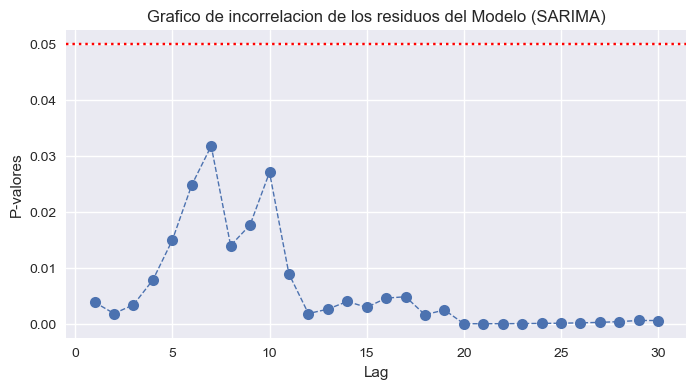

In [ ]:
# Calcula los residuos del modelo en el conjunto de entrenamiento
residuos_train = modelo_4.resid

# Test de Ljung-Box para los primeros 20 lags
ljung_box = acorr_ljungbox(residuos_train, lags=20, return_df=True)

# Mostrar la tabla de resultados
print(ljung_box)

# Gr√°fico de los p-valores
Incorr_residuos_modelo4 = sm.stats.acorr_ljungbox(modelo_4.resid, lags=30)
plt.figure(figsize=(8,4))
plt.plot(Incorr_residuos_modelo4.lb_pvalue, marker='o', markersize=8,
         linestyle='--', linewidth=1)
plt.title("Grafico de incorrelacion de los residuos del Modelo (SARIMA)")
plt.xlabel("Lag")
plt.ylabel("P-valores")
plt.axhline(0.05, color='red', linestyle=':')  # nivel de significancia 5%
plt.grid(True)
plt.show()

   - Idealmente, para un buen modelo, la mayor√≠a de los p-valores deber√≠an estar por encima de 0.05 (no significativos), lo que indicar√≠a que los residuos son ruido blanco.
   - En este caso, la presencia de autocorrelaci√≥n remanente sugiere que el modelo podr√≠a mejorarse, por ejemplo considerando variables ex√≥genas. Sin embargo, primero se va a analizar si pron√≥stico de este modelo es suficientemente bueno para el objetivo.

6. Test de estabilidad de par√°metros (CUSUM)

CUSUM statistic: 0.839740790252595
P-value: 0.48103561248603327
Critical value (5%): [(1, 1.63), (5, 1.36), (10, 1.22)]


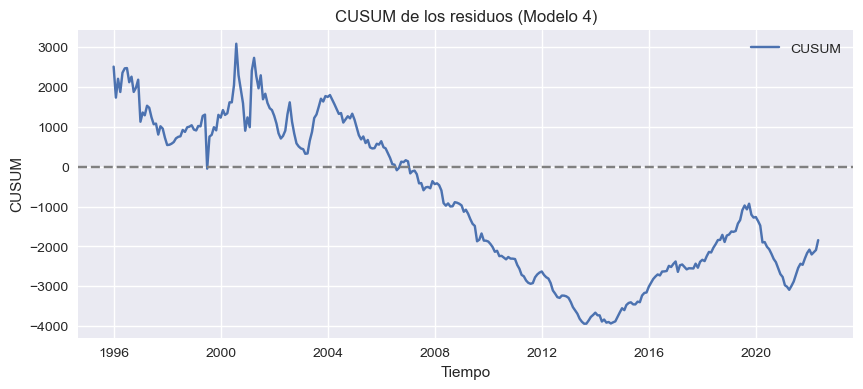

In [93]:
# Calcula los residuos del modelo 4
residuos = modelo_4.resid.dropna()

# Test CUSUM de los residuos (OLS)
cusum_stat, p_value, crit_value = breaks_cusumolsresid(residuos, ddof=0)

print(f"CUSUM statistic: {cusum_stat}")
print(f"P-value: {p_value}")
print(f"Critical value (5%): {crit_value}")

# Gr√°fico de la suma acumulada de residuos (CUSUM)
cusum = np.cumsum(residuos)
plt.figure(figsize=(10,4))
plt.plot(cusum, label='CUSUM')
plt.axhline(0, color='grey', linestyle='--')
plt.title("CUSUM de los residuos (Modelo 4)")
plt.xlabel("Tiempo")
plt.ylabel("CUSUM")
plt.legend()
plt.grid(True)
plt.show()

> El test CUSUM aplicado a los residuos muestra que los par√°metros del modelo son estables.

----
## 11. Forecast 

1. Ajustar el modelo SARIMAX a toda la serie


In [ ]:
# Ajusta el modelo SARIMAX a toda la serie (no solo train)
model_full = SARIMAX(
    serie,
    order=(1,1,1),
    seasonal_order=(1,0,1,12),  # Usa los mejores par√°metros encontrados
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_full = model_full.fit(disp=False)

# Mostrar resumen
print(results_full.summary())

                                     SARIMAX Results                                      
Dep. Variable:             produccion_gas_natural   No. Observations:                  353
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2271.626
Date:                            Wed, 09 Jul 2025   AIC                           4553.253
Time:                                    01:01:23   BIC                           4572.368
Sample:                                01-01-1996   HQIC                          4560.871
                                     - 05-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5010      0.047     10.672      0.000       0.409       0.593
ma.L1         -0.8791      0.042   

2. Pron√≥stico a 12 meses


In [70]:
# Pron√≥stico a 12 meses
n_forecast = 12
fc = results_full.get_forecast(steps=n_forecast)
pred = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

3. Crear √≠ndice futuro de 12 meses


In [71]:
last_date = serie.index[-1]
future_index = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=n_forecast,
    freq=serie.index.freq or 'MS'
)
pred.index = future_index
ci.index = future_index

4. Graficar hist√≥rico + pron√≥stico + IC 95%


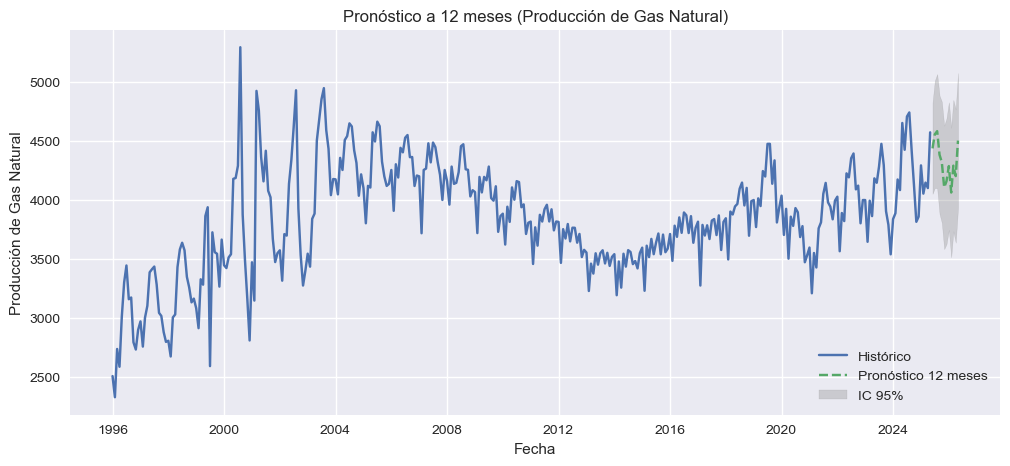

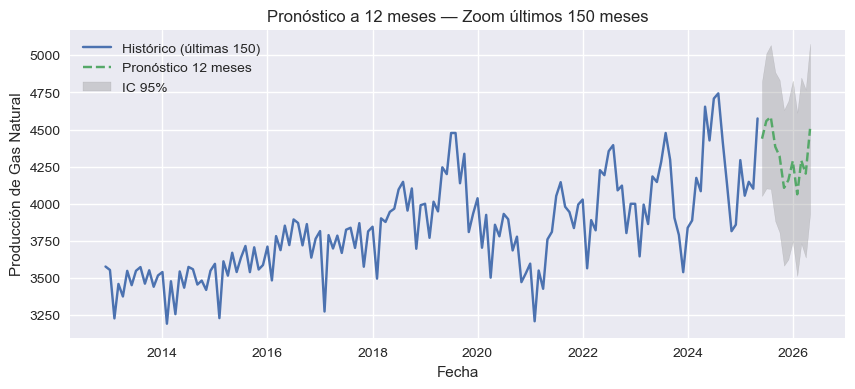

In [72]:
plt.figure(figsize=(12,5))
plt.plot(serie, label='Hist√≥rico')
plt.plot(pred, '--', label='Pron√≥stico 12 meses')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3, label='IC 95%')
plt.title("Pron√≥stico a 12 meses (Producci√≥n de Gas Natural)")
plt.xlabel("Fecha")
plt.ylabel("Producci√≥n de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()

# Zoom para ver mejor el forecast (√∫ltimos 150 meses)
hist_tail = serie.tail(150)
plt.figure(figsize=(10,4))
plt.plot(hist_tail, label='Hist√≥rico (√∫ltimas 150)')
plt.plot(pred, '--', label='Pron√≥stico 12 meses')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3, label='IC 95%')
plt.title("Pron√≥stico a 12 meses ‚Äî Zoom √∫ltimos 150 meses")
plt.xlabel("Fecha")
plt.ylabel("Producci√≥n de Gas Natural")
plt.legend()
plt.grid(True)
plt.show()